Here a sensitivity test is performed with the aim of figuring out what values of lex, sal, Tsur and rho that would fit as good start guesses

In [1]:
## Import relevant packages
import numpy as np
import matplotlib.pyplot as plt
import pyOptimalEstimation as pyOE
import os
import sys
import re
import scipy.stats as stats
import seaborn as sns

## append paths
sys.path.append('C:/Users/Ida Olsen/Documents/Speciale_2022/scripts')
parrent_dir = "C:\\Users\\Ida Olsen\\Documents\\Speciale_2022"
sys.path.append(parrent_dir + '\\smrt')
sys.path.append(parrent_dir + '\\Ida_passive_SMRT\\Ida_passive_SMRT\\Code')

## Import SMRT packages
from smrt.permittivity.saline_snow import saline_snow_permittivity_scharien_with_stogryn95 as ssp
from smrt import make_ice_column, make_interface, make_snowpack, sensor_list
from smrt.core.globalconstants import PSU
from smrt import make_model
from smrt.interface.iem_fung92_brogioni10 import IEM_Fung92_Briogoni10
from smrt import SMRTError
from IPython.display import clear_output
from sklearn.linear_model import LinearRegression

## self made modules
from Snowpit_class import Snowpit_info
from roughness import roughness
from Make_plots import plot_freq
from forward_functions import forward_mean, forward_OIB
from prepare_inputs_OE import prepare_inputs, prepare_inputs_FYI
import prepare_inputs_OE as piO

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Feb 21 09:55:04 2023

@author: Ida Olsen
"""

import netCDF4 as nc
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
## Home made modules     
from polar_plots_pred import plot_one as po
from polar_plots_pred import polar_plot as pp
# plot path
pp = "C:/Users/Ida Olsen/Documents/Speciale_2022/figures"
  
class data():
    
    # init method or constructor
    def __init__(self, filename, dtype, ice_type=-1, empty=False):
        if empty == False:
            names = ["latitude","longitude","time","identification","sd_mean","sd_std","SDln","sit_mean","sit_std","SITln","FRB","FRBstd","Tsur","Tair","wsd","wdensity","lat1","lon1","time1","reference-id","69GHzH","69GHzV","73GHzH","73GHzV","107GHzH","107GHzV","187GHzH","187GHzV","238GHzH","238GHzV","365GHzH","365GHzV","890GHzH","890GHzV","Earth Incidence","Earth Azimuth","scanpos","upstreamfile","timediff","latitude2","longitude2","time2","reference-id2","upstreamfile","msl","u10","v10","ws","t2m","skt","istl1","istl2","istl3","istl4","sst","d2m","tcwv","tclw","tciw","ssrd","strd","e","tp","sf","fal","siconc","latitude3","longitude3","time3","reference-id3","upstreamfile","sigma_40","sigma_40_mask","nb_samples","warning","std","latitude4","longitude4","time4","reference-id4","upstreamfile","SMOS_Tbv","SMOS_Tbh","SMOS_RMSE_v","SMOS_RMSE_h","SMOS_nmp","SMOS_data1loss"]
            #print(filename)
            if "-NERSC-" in filename:
                print(filename)
                data1 = np.genfromtxt(filename, names=True, dtype=dtype,
                                     skip_header=1, delimiter=',', encoding='utf8')
            else:
                data1 = np.genfromtxt(filename, names=names, dtype=dtype,
                                     skip_header=1, delimiter=',', encoding='utf8')
    
            # self.subset   = []
            self.sd       = data1['sd_mean']
            self.sit      = data1['sit_mean']
    
            index_SD  = ~np.isnan(self.sd)
            index_SIT = ~np.isnan(self.sit)
            index = [(isd and isit) for isd,isit in zip(index_SD, index_SIT)]
            self.index = index
            if ice_type!=-1:
                index = np.where(self.index)[0][ice_type]
                self.index = index
                # print(index)
    
            self.sd       = data1['sd_mean'][index]
            self.sit      = data1['sit_mean'][index]
            self.lat      = data1['latitude'][index]
            self.lon      = data1['longitude'][index]
            self.date     = data1['time'][index]
            self.id       = data1['identification'][index]
            self.sd_std   = data1['sd_std'][index]
            self.sit_std  = data1['sit_std'][index]
            try:
                self.slope    = data1['surface_roughness_mean'][index]
                self.slope_std= data1['surface_roughness_std'][index]
            except:
                self.slope    = [np.nan for el in range(len(self.lat))]
                self.slope_std= [np.nan for el in range(len(self.lat))]
            self.t2m      = data1['t2m'][index]
            self.skt      = data1['skt'][index]
            self.tcwv     = data1['tcwv'][index]
            
            try:
                ## AMSR2 V
                self.tb6V     = data1['69V'][index]
                self.tb7V     = data1['73V'][index]
                self.tb10V    = data1['107V'][index]
                self.tb18V    = data1['187V'][index]
                self.tb23V    = data1['238V'][index]
                self.tb36V    = data1['365V'][index]
                self.tb89V    = data1['890V'][index]
                
                ## AMSR2 H
                self.tb6H     = data1['69H'][index]
                self.tb7H     = data1['73H'][index]
                self.tb10H    = data1['107H'][index]
                self.tb18H    = data1['187H'][index]
                self.tb23H    = data1['238H'][index]
                self.tb36H    = data1['365H'][index]
                self.tb89H    = data1['890H'][index]
            except:
                self.tb6V     = data1['69GHzV'][index]
                self.tb7V     = data1['73GHzV'][index]
                self.tb10V    = data1['107GHzV'][index]
                self.tb18V    = data1['187GHzV'][index]
                self.tb23V    = data1['238GHzV'][index]
                self.tb36V    = data1['365GHzV'][index]
                self.tb89V    = data1['890GHzV'][index]
                
                ## AMSR2 H
                self.tb6H     = data1['69GHzH'][index]
                self.tb7H     = data1['73GHzH'][index]
                self.tb10H    = data1['107GHzH'][index]
                self.tb18H    = data1['187GHzH'][index]
                self.tb23H    = data1['238GHzH'][index]
                self.tb36H    = data1['365GHzH'][index]
                self.tb89H    = data1['890GHzH'][index]
            
            ## Gradient ratio
            self.GR_69_187_V  = (self.tb18V-self.tb6V)/(self.tb18V+self.tb6V)
            self.GR_187_365_V = (self.tb36V-self.tb18V)/(self.tb36V+self.tb18V)
            self.sigma40      = data1['sigma_40'][index]
            
            self.TbV_AMSR = [[tb6V, tb10V, tb18V, tb23V, tb36V] for tb6V, tb10V, tb18V, tb23V, tb36V
                             in zip(self.tb6V, self.tb10V, self.tb18V, self.tb23V, self.tb36V)]
            self.TbH_AMSR = [[tb6H, tb10H, tb18H, tb23H, tb36H] for tb6H, tb10H, tb18H, tb23H, tb36H
                             in zip(self.tb6H, self.tb10H, self.tb18H, self.tb23H, self.tb36H)]
        elif empty == True:

            # self.subset   = []
            self.sd       = []
            self.sit      = []
            self.index    = []
            self.lat      = []
            self.lon      = []
            self.date     = []
            self.id       = []
            self.sd_std   = []
            self.sit_std  = []
            self.slope     = []
            self.slope_std = []
            self.t2m      = []
            self.skt      = []
            self.tcwv     = []
            ## AMSR2 V
            self.tb6V     = []
            self.tb7V     = []
            self.tb10V    = []
            self.tb18V    = []
            self.tb23V    = []
            self.tb36V    = []
            self.tb89V    = []
            
            ## AMSR2 H
            self.tb6H     = []
            self.tb7H     = []
            self.tb10H    = []
            self.tb18H    = []
            self.tb23H    = []
            self.tb36H    = []
            self.tb89H    = []
            
            ## Gradient ratio
            self.GR_69_187_V  = []
            self.GR_187_365_V = []
            self.sigma40      = []
            
            self.TbV_AMSR = []
            self.TbH_AMSR = []
            
    def concatenate(self, obj2):
        " Concatenate two class objects e.g. combine to one"
        # update directory of obj1 with informaiton from obj2
        # self.__dict__.update(obj2.__dict__)
        
        for dict1, dict2 in zip(self.__dict__.items(), obj2.__dict__.items()):
            # dict[0] = keys e.g. class names
            # dict[1] = values in keys e.g. values of a given key
            setattr(self, dict1[0], np.append(dict1[1],dict2[1]))

    def plot(self, varname):

        if varname in self.__dict__.keys():
            var=self.__dict__.get(varname)
            title = ('OIB distribution of ' + varname.upper())
            if self.subset == "FYI":
                # clim = [1, 2]
                clim = [240,260]
            elif self.subset == "MYI":
                clim = [2, 6]
            else: # snow values
                clim = [0, 1]
            po(self.lat, self.lon, var, title + " " + self.subset, ylabel=varname.upper() + ' [m]', clim=clim, s=10)
        else:
            print('ERROR variable in in class')
            print('Class attributes are:', self.__dict__.keys())

def Get_OIB_data(directory_path, all_data=True,plot=False):

    # directory_path = os.path.dirname(os.path.dirname(os.getcwd()))
    if all_data==True:
        datafolder= "ALL_DATA" #"2013-2019"
    elif all_data=="old":
        datafolder= "2009-2015"
    elif all_data=="new":
        datafolder= "2016-2019"
    sourcedir = directory_path + "/RRDP_v2.2/NERSC_OIB/"+datafolder+"/*.text"
    file = "QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20150403.TEXT"

    files = os.listdir(directory_path +  "/RRDP_v2.2/NERSC_OIB/"+datafolder+"/")
    ifile = os.path.join(directory_path, "RRDP_v2.2/NERSC_OIB/"+datafolder+"/" + files[0])
    dtype = float
    ## make empty class object
    d_final_FYI = data(ifile, dtype, [])
    d_final_MYI = data(ifile, dtype, [])
    
    ## loop throguh files
    for file in files:
        filename = os.path.join(directory_path, "RRDP_v2.2/NERSC_OIB/"+datafolder+"/" + file)
        data_np = np.genfromtxt(filename, skip_header=1, delimiter=',', encoding='utf8')
        if "-NERSC-" in filename:
            dtype = [float if (e!=2 and e!=3 and e!=21 and e!=22 and e!=23) else object for e in list(range(data_np.shape[1]))]
        else:
            dtype = [float if (e!=2 and e!=3) else object for e in list(range(data_np.shape[1]))]
        print(filename)
        d = data(filename, dtype)            
        #% FYI/MYI based on scatter  
        ## exclude the 10% of measurements with the heighest std
        exclude_points_SD = int(len(d.sd_std)/10)
        exclude_points_SIT = int(len(d.sit_std)/10)
        
        ## argpartition (orders based on size)
        ind_SD = np.argpartition(d.sd_std, -exclude_points_SD)[-exclude_points_SD:]
        ind_SIT = np.argpartition(d.sit_std, -exclude_points_SIT)[-exclude_points_SIT:]
        
        FYI = [];
        MYI = [];
        
        for i in range(len(d.GR_69_187_V)):
            if d.GR_69_187_V[i]<0.015 and d.GR_187_365_V[i]>-0.03 and d.sigma40[i]<-16.5 and d.sit[i]<2.0 and any(i!=ind_SD) and any(i!=ind_SIT):
                FYI.append(i)
            elif d.GR_69_187_V[i]<0 and d.GR_187_365_V[i]<-0.06 and d.sigma40[i]>-12 and d.sit[i]>2 and any(i!=ind_SD) and any(i!=ind_SIT):
                MYI.append(i)
        
        d_FYI = data(filename, dtype, FYI)
        d_MYI = data(filename, dtype, MYI)
    
        ## Make final class object with FYI and MYI data
        d_final_FYI.concatenate(d_FYI)
        d_final_MYI.concatenate(d_MYI)
        
        d_final_FYI.subset = "FYI"
        d_final_MYI.subset = "MYI"
    if plot==True:
        d_final_FYI.plot('sit')
        d_final_MYI.plot('sit')
    return [d_final_FYI, d_final_MYI]


def make_hist(var, varname, name='OIB'):
    try:
        var = np.concatenate(var)
    except:
        pass
    avgvar=np.nanmean(np.array(var))
    stdvar=np.nanstd(np.array(var))
    fig, ax= plt.subplots()
    if varname=='SIT':
        unit = ' [m]'
        plt.xlim(xmax=7,xmin=0)
        bins = np.linspace(-10, 10, 100)
    elif varname=='SD':
        unit = ' [m]'
        plt.xlim(xmax=1,xmin=0)
        bins = np.linspace(-1, 1, 100)
    elif varname=='rho':
        unit = ' [kg/m^3]'
        plt.xlim(xmax=400,xmin=100)
        bins = np.linspace(100, 400, 50)
    elif varname=='lex':
        unit = ' [mm]'
        plt.xlim(xmax=0.5,xmin=0)
        bins = np.linspace(-1, 1, 100)
    elif varname=='sal':
        unit = ' [PSU]'
        plt.xlim(xmax=20,xmin=0)
        bins = np.linspace(0, 20, 50)
    elif varname=='slope':
        unit = ' '
        plt.xlim(xmax=1,xmin=0)
        bins = np.linspace(-1, 1, 100)    
    ax.hist(var, bins=bins, color='red', alpha=0.5, rwidth=0.85,label=varname + ' avg:'+str(np.round(avgvar,2))+' ,std of: '+str(np.round(stdvar,2)))
    plt.grid(axis='y',alpha=0.75)
    # plt.ylim(ymax=650,ymin=0)
    if varname in ['sal', 'lex', 'rho']:
        plt.title('Simulation values of ' + varname ,fontsize=14,fontweight='bold')
    else:
        plt.title('Distribution of '+ name +' ' + varname + ' measurements',fontsize=14,fontweight='bold')
    plt.xlabel(varname + unit,fontsize=12)
    plt.legend(prop={"size":12}, bbox_to_anchor=(1.0, -0.15))
    plt.ylabel('Count',fontsize=14)
    plt.savefig(os.path.join(pp, 'OE_figures/hist_' + varname + '.png'), bbox_inches='tight')
    plt.show()



In [3]:
directory_path = os.path.dirname(os.path.dirname(os.getcwd()))
[d_final_FYI, d_final_MYI] = Get_OIB_data(directory_path, all_data=True,plot=False)

C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR-vs-ERA-vs-NERSC-OIB-20090331.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR-vs-ERA-vs-NERSC-OIB-20090331.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR-vs-ERA-vs-NERSC-OIB-20090331.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR-vs-ERA-vs-NERSC-OIB-20090331.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR-vs-ERA-vs-NERSC-OIB-20090331.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR-vs-ERA-vs-NERSC-OIB-20090331.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR-vs-ERA-vs-NERSC-OIB

C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20130322.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20130323.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20130323.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20130323.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20130323.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20130324.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NE

C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20140321.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20140321.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20140324.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20140324.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20140324.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20140324.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NE

C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20150403.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/SMOS-vs-ASCAT-vs-ERA5-vs-refAMSR2-vs-2016_OIB_RRDB.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/SMOS-vs-ASCAT-vs-ERA5-vs-refAMSR2-vs-2017_OIB_RRDB.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/SMOS-vs-ASCAT-vs-ERA5-vs-refAMSR2-vs-2018_OIB_RRDB.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/SMOS-vs-ASCAT-vs-ERA5-vs-refAMSR2-vs-2019_OIB_RRDB.text


In [4]:
def SMRT_simulation(self):
    ## Make icepack           
    sea_ice_density = 900
    icepack = make_ice_column(ice_type='firstyear',
            thickness=[self.sit], 
            temperature=[self.T_sii], 
            microstructure_model='exponential',
            corr_length=[self.sit_lex],
            brine_inclusion_shape='spheres',
            density=sea_ice_density,
            salinity=[self.sit_sal],
            add_water_substrate="ocean")

    snowpack = make_snowpack(self.sd, 
                    microstructure_model='exponential',
                    ice_permittivity_model=ssp, 
                    density=self.rho, 
                    corr_length=self.lex, 
                    temperature = self.Tsnow,
                    salinity=self.sal)

    
    medium = snowpack + icepack
    
    
    m = make_model("iba", "dort")
    
    frequencies=np.array([6.925e9,10.65e9,18.7e9,23.8e9,36.5e9]);  # [Hz]
    
    beamorientation = 55. # [degrees]
    sensor = sensor_list.passive(frequencies, beamorientation)
    
    #% Run simulations
    res = m.run(sensor, medium)
    
    # #% adjust for atmospheric influence
    m = self.m

    [TB_AMSR_V,TB_AMSR_H, Gamma_rs_H, Gamma_rs_V, QH, QV] = roughness(self.tcwv,res,self.T_sii, m=m)
    
    if self.pol=='V':
        return TB_AMSR_V 
    else:
        return [TB_AMSR_V,TB_AMSR_H]


In [5]:
FYI_data = piO.OIB_data('FYI')

FYI_OIB_SIM = np.concatenate([np.mean(FYI_data.TbV_sim, axis=0), np.mean(FYI_data.TbH_sim, axis=0)])
FYI_OIB_AMSR = np.concatenate([np.mean(FYI_data.TbV_AMSR_all, axis=0), np.mean(FYI_data.TbH_AMSR_all, axis=0)])
FYI_OIB_AMSR_std = np.concatenate([np.std(FYI_data.TbV_AMSR_all, axis=0), np.std(FYI_data.TbH_AMSR_all, axis=0)])



Starting point based on values from CB. Focus on vertical polarization

In [6]:
## Plots results
#plt.figure(figsize=(8,6))
frequencies=[6.925e9,10.65e9,18.7e9,23.8e9,36.5e9];
freqs = [f*1e-9 for f in frequencies]

#y = FYI_OIB_AMSR[:5]
#plt.plot(freqs, y, c='r',label = 'TBV Avg. AMSR2')
#y = OIB_AMSR
#plt.plot(freqs, y, c='r',label = 'TBV Avg. AMSR2')
#y = FYI_OIB_AMSR[5:]
#plt.plot(freqs,y, c='b', label = 'TBH Avg. AMSR2')
y = FYI_OIB_SIM[:5]
#plt.plot(freqs, y, c='k', label = 'TBV Avg. SIM')
y = FYI_OIB_SIM[5:]
#plt.plot(freqs, y, c='green', label = 'TBH Avg. SIM')
#plt.grid()
#plt.ylim([200,270])
#plt.legend()
#plt.xlabel('Freq GHz')
#plt.ylabel('TB [K]')
#plt.title('Simulated FYI TBs from OIB data 2013-2019')
# plt.savefig(os.path.join(self.pp, 'OE_figures/Simulated_data.png'), bbox_inches='tight')
#plt.show()

In [7]:
## OIB VALUES
print('lex: ', np.mean(FYI_data.sd_lex, axis=0)*1e3)
print('rho: ', np.mean(FYI_data.sd_rho, axis=0))
print('sal: ', np.mean(FYI_data.sd_sal, axis=0)*1e3)

lex:  [0.21487592 0.25216876]
rho:  [348.53339933 337.51818972]
sal:  [0.88802032 8.67319838]


In [8]:
np.mean(d_final_FYI.sd)
np.mean(d_final_FYI.sit)

1.448462962962963

Values not changing:
SD, SIT

In [9]:
sd_tot = np.mean(np.sum(FYI_data.sd, axis=1))
print(sd_tot)

0.1356732394366197


In [10]:
class smrt_values():
    # init method or constructor
    def __init__(self, OIB_data, frac=0.25):
        #
        self.pol = 'both'
        self.Tsur = np.mean(OIB_data.skt)
        self.m = 0.19 # roughness variable
        self.tcwv = np.mean(OIB_data.tcwv) #total columnar water vapour
        self.ks = 0.25
        # Snow variables
        #sd = np.mean(OIB_data.sd, axis=0)
        #print(sd)
        # self.sd = [np.mean(OIB_data.sd, axis=0)[0]-0.03, 0.06]
        sd_tot = np.mean(np.sum(OIB_data.sd, axis=1))
        sd0 = sd_tot - sd_tot*frac
        sd1 = sd_tot*frac - 0.01
        sd2 = 0.01
        #sd0 = sd_tot - sd_tot*frac
        #sd1 = sd_tot*frac
        self.sd = [sd0, sd1, sd2]
        #self.sd = [sd0, sd1]
        self.lex = [0.24e-3, 0.37e-3, 0.37e-3] ## mm - based on paper by Wisman and Metzler
        #self.lex = [0.223e-3, 0.35e-3]
        self.sal = [0.001*PSU, 0.5*PSU, 13*PSU]  # Based on CB field observations 
        #self.sal = [0.01*PSU, 2.5*PSU]
        self.rho = [350, 270, 270] # based on paper by Wisman and Metzler
        #self.rho = [350, 320]
        # Ice varibles
        self.sit = np.mean(OIB_data.sit)
        self.sit_lex = 0.15e-3
        self.sit_sal = 6*PSU
        # Temperatures
    def calc_temp(self, plot=True):
        k = 2.10 # thermal conductivity FYI
        T_w = (273.15-1.8)  # Ocean temperature [K]
        ks = self.ks # Thermal conductivity of snow [w/(m*K)]

        ## snow ice interface temperature
        self.T_sii = (k * np.sum(self.sd) * T_w + ks * self.sit *
                    self.Tsur) / (k * np.sum(self.sd) + ks * self.sit)

        x = [0, np.sum(self.sd)]
        y = [self.Tsur, self.T_sii]
        model = LinearRegression().fit(np.array(x).reshape(-1,1), np.array(y))
        xx = np.array([self.sd[0]/2, self.sd[0] + self.sd[1]/2, self.sd[0]+ self.sd[1] + self.sd[2]/2] ).reshape(-1,1)
        # xx = np.array([self.sd[0]/2, self.sd[0] + self.sd[1]/2]).reshape(-1,1)
        # print(self.sd)
        # xx = (np.array(self.sd)/2).reshape(-1,1)
        # xx = np.array([self.sd[0]/2, self.sd[0] + self.sd[1]/2, self.sd[0] + self.sd[1] + self.sd[2]/2]).reshape(-1,1)
        self.Tsnow = model.predict(xx)
        
        #if plot==True:
        # ice/snow thickness arrays for showing temperature profiles    
        ice_thick = np.array([0, -self.sit])
        t_ice = np.array([self.T_sii, T_w])
        
        #snow_thick = [np.sum(self.sd), self.sd[0]/2 + self.sd[1], self.sd[1]/2, 0]
        #t_snow = [self.Tsur] + [Ts for Ts in self.Tsnow] + [self.T_sii]

        if plot==True:
            plt.figure()
            plt.plot(t_snow, snow_thick,'.-')
            plt.plot(t_ice, ice_thick,'.-')
            plt.grid()
            plt.xlabel('Temperature [K]')
            plt.ylabel('Depth [m]')
            

In [11]:
"""
class smrt_values():
    # init method or constructor
    def __init__(self, OIB_data, frac=0.4):
        #
        self.pol = 'both'
        self.Tsur = np.mean(OIB_data.skt)
        self.m = 0.19 # roughness variable
        self.tcwv = np.mean(OIB_data.tcwv) #total columnar water vapour
        # Snow variables
        sd_tot = np.mean(np.sum(OIB_data.sd, axis=1))
        sd0 = sd_tot - sd_tot*frac
        sd1 = sd_tot*frac
        self.sd = [sd0, sd1]
        self.lex = [0.25e-3, 0.35e-3] ## mm - based on paper by Wisman and Metzler
        self.sal = [0.001*PSU, 2.5*PSU]  # Based on CB field observations 
        self.rho = [350, 280] # based on paper by Wisman and Metzler
        # Ice varibles
        self.sit = np.mean(OIB_data.sit)
        self.sit_lex = 0.15e-3
        self.sit_sal = 6*PSU
        # Temperatures
    def calc_temp(self, plot=True):
        k = 2.10 # thermal conductivity FYI
        T_w = (273.15-1.8)  # Ocean temperature [K]
        ks = 0.15 # Thermal conductivity of snow [w/(m*K)]

        ## snow ice interface temperature
        self.T_sii = (k * np.sum(self.sd) * T_w + ks * self.sit *
                    self.Tsur) / (k * np.sum(self.sd) + ks * self.sit)

        x = [0, np.sum(self.sd)]
        y = [self.Tsur, self.T_sii]
        model = LinearRegression().fit(np.array(x).reshape(-1,1), np.array(y))
        xx = np.array([self.sd[0]/2, self.sd[0] + self.sd[1]/2]).reshape(-1,1)
        # xx = np.array([self.sd[0]/2, self.sd[0] + self.sd[1]/2]).reshape(-1,1)
        # print(self.sd)
        # xx = (np.array(self.sd)/2).reshape(-1,1)
        # xx = np.array([self.sd[0]/2, self.sd[0] + self.sd[1]/2, self.sd[0] + self.sd[1] + self.sd[2]/2]).reshape(-1,1)
        self.Tsnow = model.predict(xx)
        
        #if plot==True:
        # ice/snow thickness arrays for showing temperature profiles    
        ice_thick = np.array([0, -self.sit])
        t_ice = np.array([self.T_sii, T_w])
        
        #snow_thick = [np.sum(self.sd), self.sd[0]/2 + self.sd[1], self.sd[1]/2, 0]
        #t_snow = [self.Tsur] + [Ts for Ts in self.Tsnow] + [self.T_sii]

        if plot==True:
            plt.figure()
            plt.plot(t_snow, snow_thick,'.-')
            plt.plot(t_ice, ice_thick,'.-')
            plt.grid()
            plt.xlabel('Temperature [K]')
            plt.ylabel('Depth [m]')
"""       

"\nclass smrt_values():\n    # init method or constructor\n    def __init__(self, OIB_data, frac=0.4):\n        #\n        self.pol = 'both'\n        self.Tsur = np.mean(OIB_data.skt)\n        self.m = 0.19 # roughness variable\n        self.tcwv = np.mean(OIB_data.tcwv) #total columnar water vapour\n        # Snow variables\n        sd_tot = np.mean(np.sum(OIB_data.sd, axis=1))\n        sd0 = sd_tot - sd_tot*frac\n        sd1 = sd_tot*frac\n        self.sd = [sd0, sd1]\n        self.lex = [0.25e-3, 0.35e-3] ## mm - based on paper by Wisman and Metzler\n        self.sal = [0.001*PSU, 2.5*PSU]  # Based on CB field observations \n        self.rho = [350, 280] # based on paper by Wisman and Metzler\n        # Ice varibles\n        self.sit = np.mean(OIB_data.sit)\n        self.sit_lex = 0.15e-3\n        self.sit_sal = 6*PSU\n        # Temperatures\n    def calc_temp(self, plot=True):\n        k = 2.10 # thermal conductivity FYI\n        T_w = (273.15-1.8)  # Ocean temperature [K]\n       

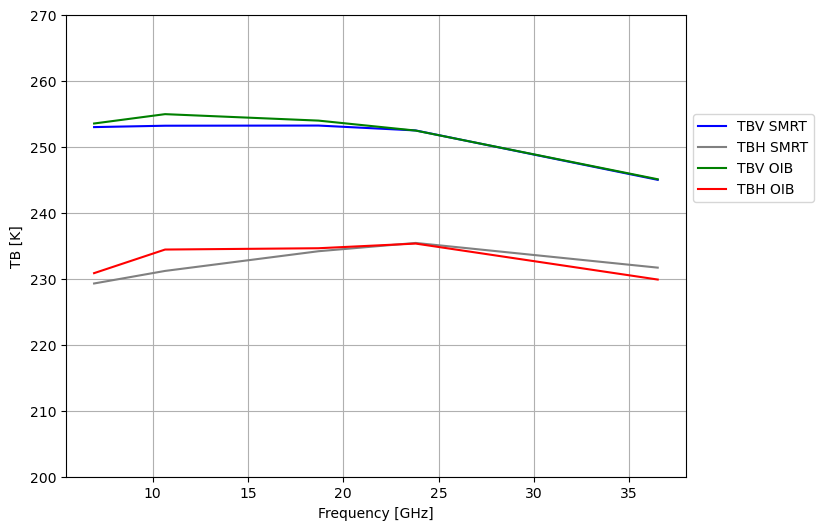

[ 0.54565973  1.75327553  0.74934051 -0.0200544   0.08776011]
[ 1.56478053  3.23997733  0.4537059  -0.09741498 -1.80358321]


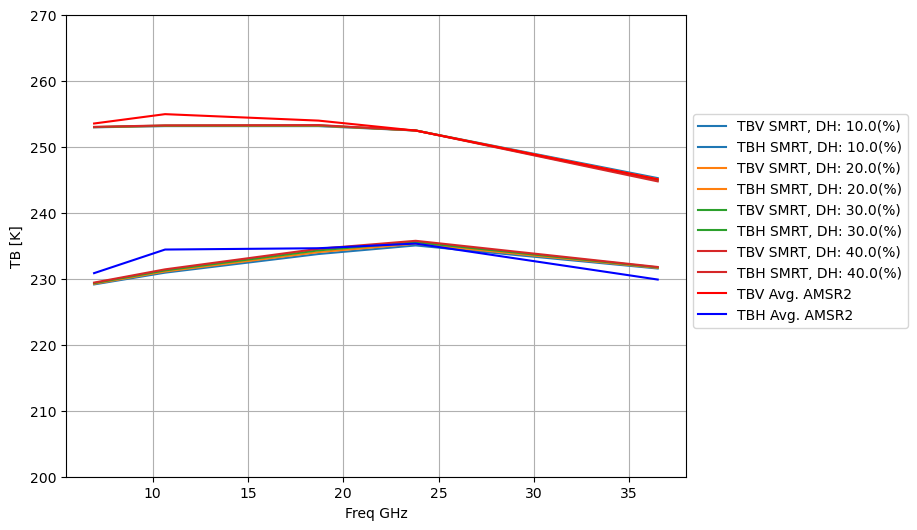

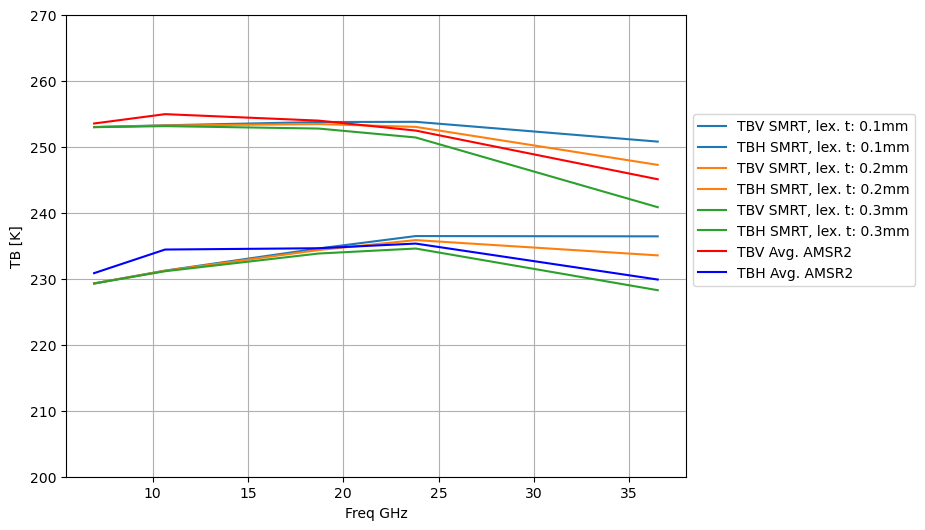

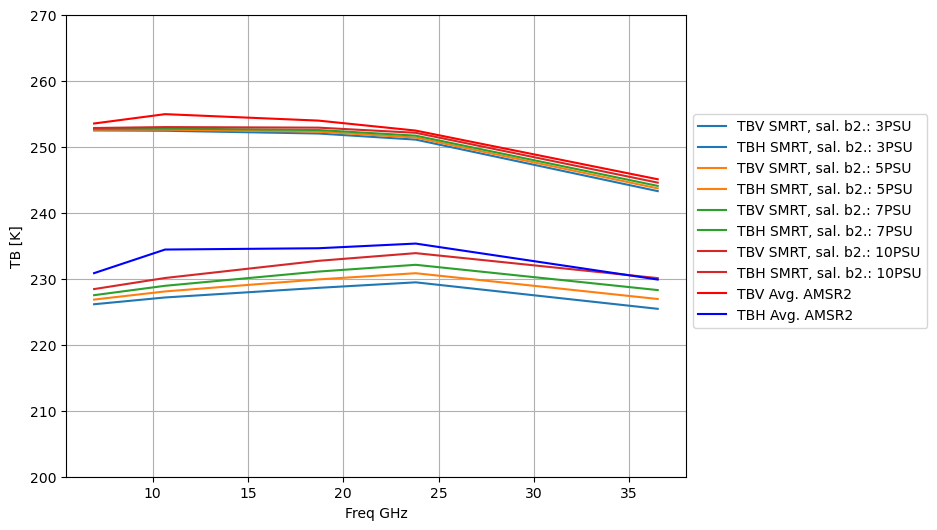

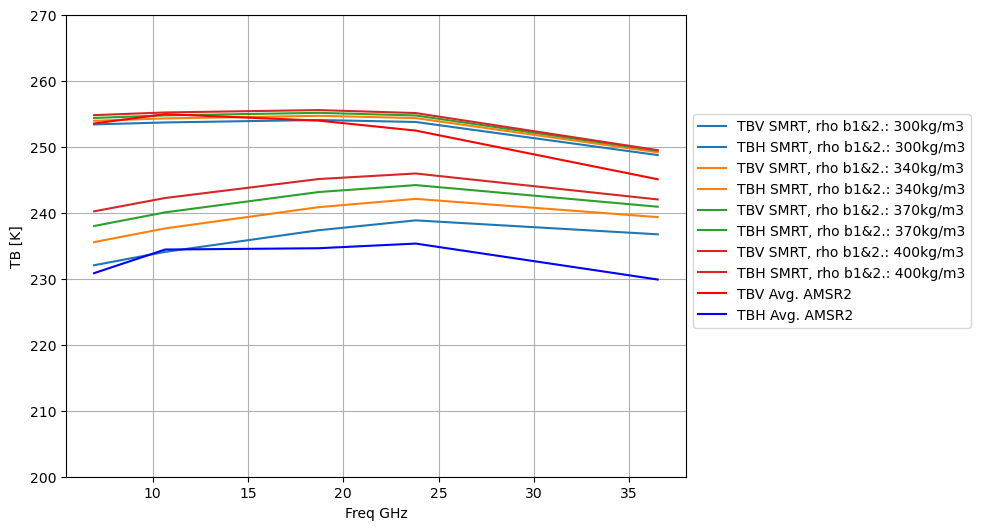

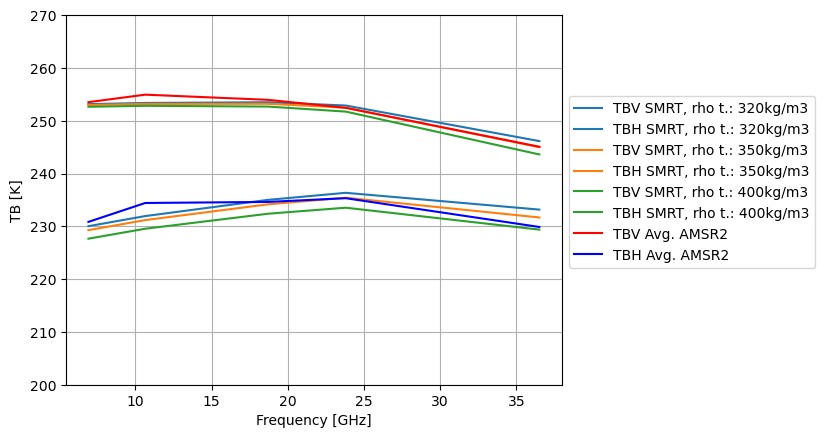

In [12]:
## Plots results
savepath = "C:/Users/Ida Olsen/Documents/Speciale_2022/Results/Real_data/Sensitivity_studies/3 layers/DH_tests/WS_DH/"

data = smrt_values(FYI_data)
data.calc_temp(plot=False)
plt.figure(figsize=(8,6))
frequencies=[6.925e9,10.65e9,18.7e9,23.8e9,36.5e9];
freqs = [f*1e-9 for f in frequencies]

colors = ['C' + str(i) for i in range(10)]

data = smrt_values(FYI_data, frac=0.25)
data.calc_temp(plot=False)
TBV, TBH = SMRT_simulation(data)
y = TBV
plt.plot(freqs, y, c='b',label = 'TBV SMRT')
y = TBH
plt.plot(freqs, y, c='grey',label = 'TBH SMRT')

y = FYI_OIB_AMSR[:5]
plt.plot(freqs, y, c='g',label = 'TBV OIB')
y = FYI_OIB_AMSR[5:]
plt.plot(freqs,y, c='r', label = 'TBH OIB')
plt.grid()
plt.ylim([200,270])
plt.legend(bbox_to_anchor=(1, 0.8))
plt.xlabel('Frequency [GHz]')
plt.ylabel('TB [K]')
plt.title('')
plt.savefig(savepath + 'DH_frac_avg_values.png', bbox_inches='tight')
plt.show()

Bias = FYI_OIB_AMSR[:5]- TBV
print(Bias)

Bias = FYI_OIB_AMSR[5:]- TBH
print(Bias)

data = smrt_values(FYI_data)
data.calc_temp(plot=False)
plt.figure(figsize=(8,6))
frequencies=[6.925e9,10.65e9,18.7e9,23.8e9,36.5e9];
freqs = [f*1e-9 for f in frequencies]

colors = ['C' + str(i) for i in range(10)]
for frac,c in zip([0.1,0.2,0.3,0.4], colors):
    data = smrt_values(FYI_data, frac=frac)
    data.calc_temp(plot=False)
    TBV, TBH = SMRT_simulation(data)
    y = TBV
    plt.plot(freqs, y, c=c,label = 'TBV SMRT, DH: ' + str(frac*100) + '(%)')
    y = TBH
    plt.plot(freqs, y, c=c,label = 'TBH SMRT, DH: ' + str(frac*100) + '(%)')

y = FYI_OIB_AMSR[:5]
plt.plot(freqs, y, c='r',label = 'TBV Avg. AMSR2')
y = FYI_OIB_AMSR[5:]
plt.plot(freqs,y, c='b', label = 'TBH Avg. AMSR2')
plt.grid()
plt.ylim([200,270])
plt.legend(bbox_to_anchor=(1, 0.8))
plt.xlabel('Freq GHz')
plt.ylabel('TB [K]')
plt.title('')
plt.savefig(savepath + 'DH_frac_avg_values.png', bbox_inches='tight')
plt.show()

## correlation length
plt.figure(figsize=(8,6))
for lex_t,c in zip([0.1*1e-3, 0.2*1e-3, 0.3*1e-3], colors):
    data = smrt_values(FYI_data)
    data.calc_temp(plot=False)
    data.lex[0] = lex_t
    TBV, TBH = SMRT_simulation(data)
    y = TBV
    plt.plot(freqs, y, c=c,label = 'TBV SMRT, lex. t: ' + str(lex_t*1e3) + 'mm')
    y = TBH
    plt.plot(freqs, y, c=c,label = 'TBH SMRT, lex. t: ' + str(lex_t*1e3) + 'mm')

y = FYI_OIB_AMSR[:5]
plt.plot(freqs, y, c='r',label = 'TBV Avg. AMSR2')
y = FYI_OIB_AMSR[5:]
plt.plot(freqs,y, c='b', label = 'TBH Avg. AMSR2')
plt.grid()
plt.ylim([200,270])
plt.legend(bbox_to_anchor=(1, 0.8))
plt.xlabel('Freq GHz')
plt.ylabel('TB [K]')
plt.title('')
plt.savefig(savepath + 'lex_avg_values.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6))
for sal_b,c in zip([3, 5, 7, 10], colors):
    data = smrt_values(FYI_data)
    data.calc_temp(plot=False)
    data.sal[2] = sal_b*PSU
    TBV, TBH = SMRT_simulation(data)
    y = TBV
    plt.plot(freqs, y, c=c,label = 'TBV SMRT, sal. b2.: ' + str(sal_b) + 'PSU')
    y = TBH
    plt.plot(freqs, y, c=c,label = 'TBH SMRT, sal. b2.: ' + str(sal_b) + 'PSU')

y = FYI_OIB_AMSR[:5]
plt.plot(freqs, y, c='r',label = 'TBV Avg. AMSR2')
y = FYI_OIB_AMSR[5:]
plt.plot(freqs,y, c='b', label = 'TBH Avg. AMSR2')
plt.grid()
plt.ylim([200,270])
plt.legend(bbox_to_anchor=(1, 0.8))
plt.xlabel('Freq GHz')
plt.ylabel('TB [K]')
plt.title('')
plt.savefig(savepath + 'sal_avg_values.png', bbox_inches='tight')
plt.show()


plt.figure(figsize=(8,6))

for rho_b,c in zip([300, 340, 370, 400], colors):
    data = smrt_values(FYI_data)
    data.calc_temp(plot=False)
    data.rho[1] = rho_b
    data.rho[2] = rho_b
    TBV, TBH = SMRT_simulation(data)
    y = TBV
    plt.plot(freqs, y, c=c,label = 'TBV SMRT, rho b1&2.: ' + str(rho_b) + 'kg/m3')
    y = TBH
    plt.plot(freqs, y, c=c,label = 'TBH SMRT, rho b1&2.: ' + str(rho_b) + 'kg/m3')

y = FYI_OIB_AMSR[:5]
plt.plot(freqs, y, c='r',label = 'TBV Avg. AMSR2')
y = FYI_OIB_AMSR[5:]
plt.plot(freqs,y, c='b', label = 'TBH Avg. AMSR2')
plt.grid()
plt.ylim([200,270])
plt.legend(bbox_to_anchor=(1, 0.8))
plt.xlabel('Freq GHz')
plt.ylabel('TB [K]')
plt.title('')
plt.savefig(savepath + 'rho_avg_values.png', bbox_inches='tight')
plt.show()

for rho_t,c in zip([320, 350, 400], colors):
    data = smrt_values(FYI_data)
    data.calc_temp(plot=False)
    data.rho[0] = rho_t
    TBV, TBH = SMRT_simulation(data)

    #Bias_TBV = [ -2.08, -0.46, -0.41, -0.55, 0.3]
    #Bias_TBH = [ 0.22, 0.65, -2.48, -2.6, -3.32]

    #TBV = TBV + Bias_TBV
    #TBH = TBH + Bias_TBH

    y = TBV
    plt.plot(freqs, y, c=c,label = 'TBV SMRT, rho t.: ' + str(rho_t) + 'kg/m3')
    y = TBH
    plt.plot(freqs, y, c=c,label = 'TBH SMRT, rho t.: ' + str(rho_t) + 'kg/m3')

y = FYI_OIB_AMSR[:5]
plt.plot(freqs, y, c='r',label = 'TBV Avg. AMSR2')
y = FYI_OIB_AMSR[5:]
plt.plot(freqs,y, c='b', label = 'TBH Avg. AMSR2')
plt.grid()
plt.ylim([200,270])
plt.legend(bbox_to_anchor=(1, 0.8))
plt.xlabel('Frequency [GHz]')
plt.ylabel('TB [K]')
plt.title('')
plt.savefig(savepath + 'rho_t_avg_values.png', bbox_inches='tight')
plt.show()

253.0837746478873


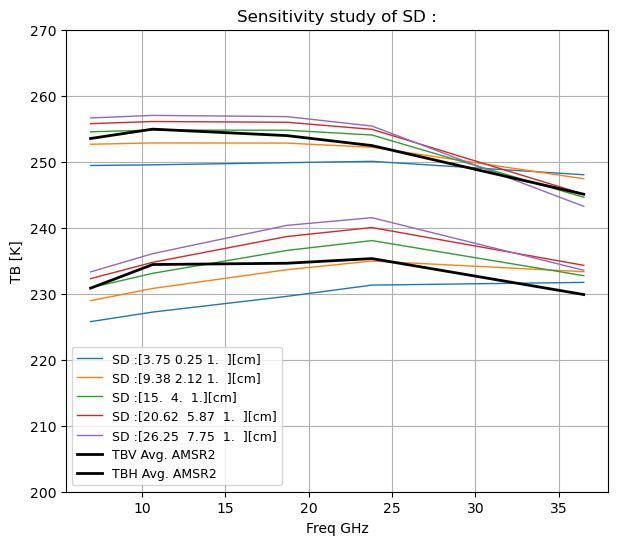

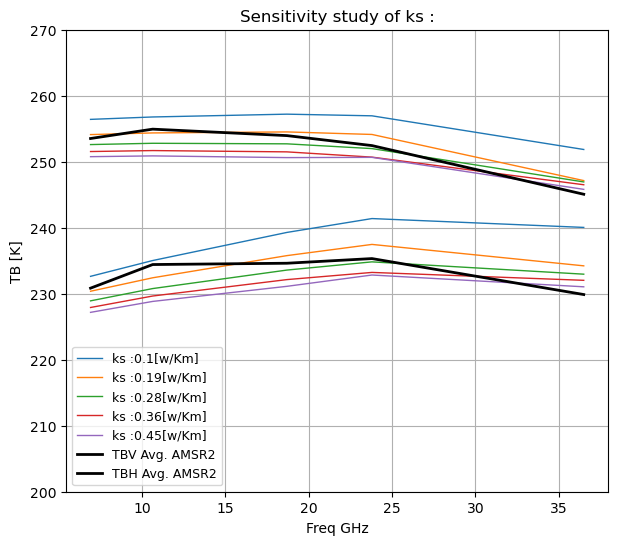

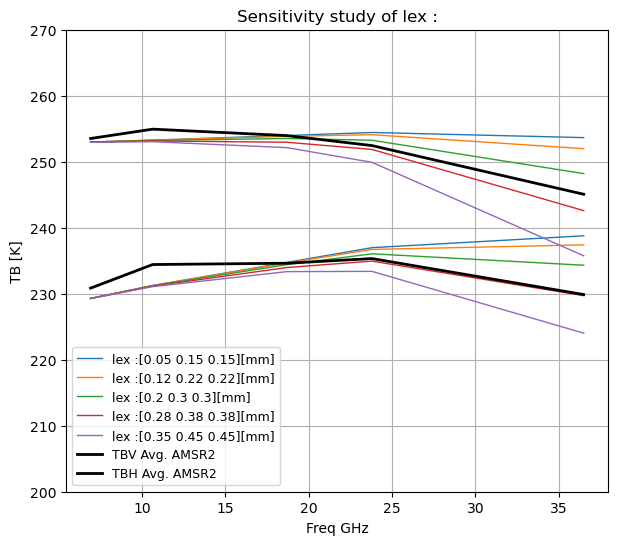

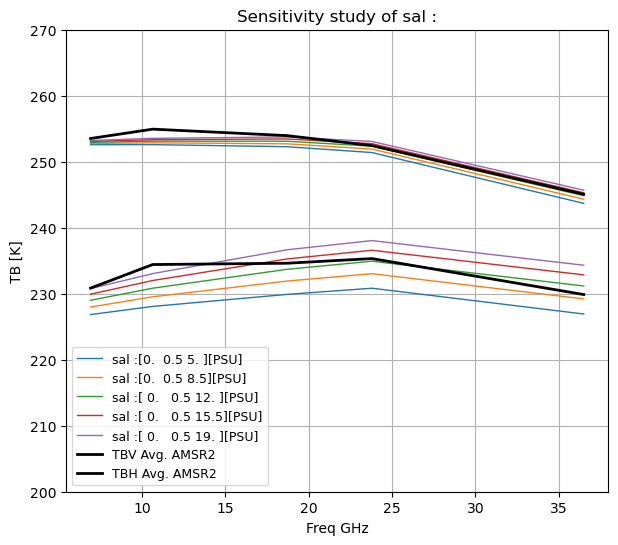

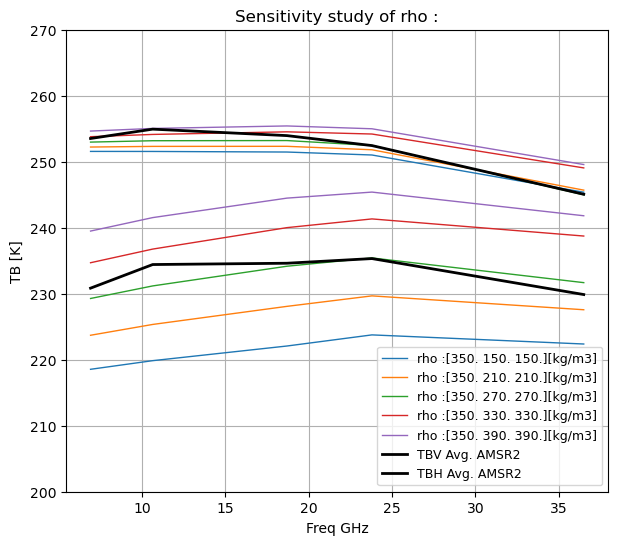

248.0837746478873
Tsur :
250.5837746478873
Tsur :
253.0837746478873
Tsur :
255.5837746478873
Tsur :
258.0837746478873
Tsur :


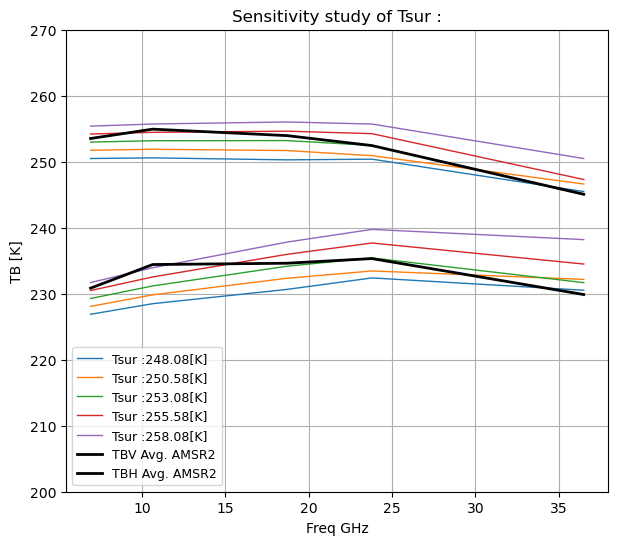

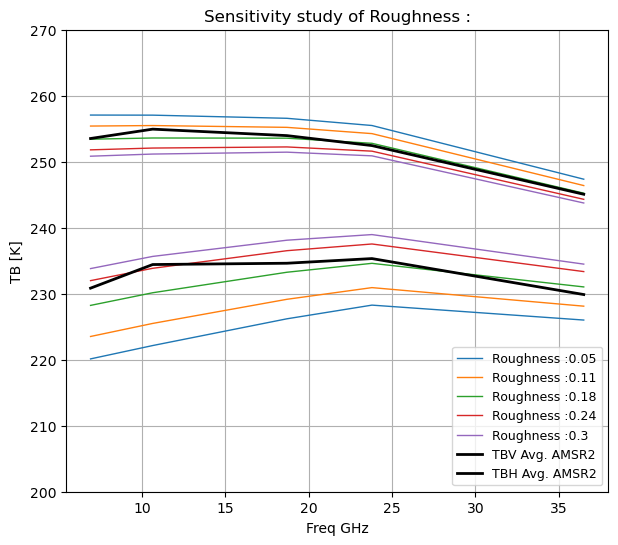

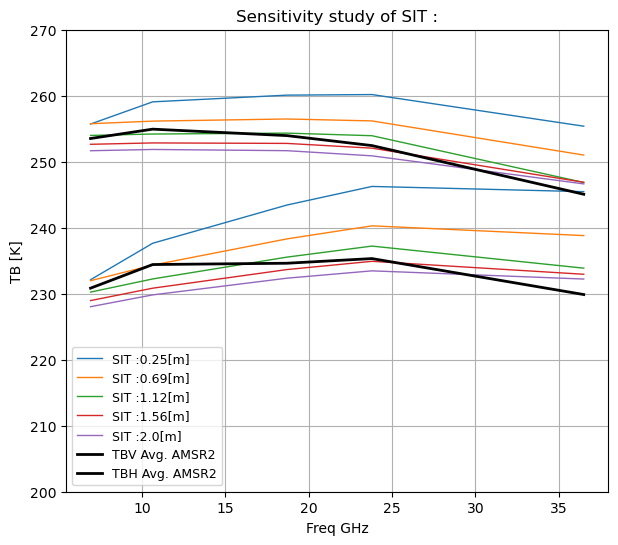

In [22]:
savepath = "C:/Users/Ida Olsen/Documents/Speciale_2022/Results/Real_data/Sensitivity_studies/3 layers/DH_FIGURES/"
nupo = 5
DH_fraction = 0.25
SD_range = np.linspace(0.05, 0.35, nupo)
ks_range = np.linspace(0.10, 0.45, nupo)
lex_range = np.linspace(0.05e-3, 0.35e-3, nupo)
sal_range = np.linspace(1*PSU, 15*PSU, nupo)
rho_range = np.linspace(150, 390, nupo)

colors = ['C' + str(i) for i in range(nupo)]
# 
print(data.Tsur)
Tsur_range = np.linspace(data.Tsur-5, data.Tsur+5, nupo)
m_range = np.linspace(0.05, 0.3, nupo)
sit_range = np.linspace(0.25, 2.0, nupo)

# ranges = [SD0_range, SD1_range,lex0_range, lex1_range, sal0_range,
#           sal1_range, rho0_range, rho1_range, Tsur_range, m_range, sit_range]
ranges = [SD_range, ks_range, lex_range, sal_range, rho_range, Tsur_range, m_range, sit_range]

#variables = ['SD0 :', 'SD1 :', 'lex0 :', 'lex1 :', 'sal0 :',
#             'sal1 :', 'rho0 :', 'rho1 :', 'Tsur :', 'slope (m) :', 'SIT :']
variables = ['SD :','ks :', 'lex :', 'sal :', 'rho :', 'Tsur :', 'Roughness :', 'SIT :']
units = ['[cm]','[w/Km]', '[mm]', '[PSU]','[kg/m3]', '[K]', '', '[m]']


sim_TBV = []
sim_TBH = []
## Plots results
for rangee, var_name, unit in zip(ranges, variables, units):
    #print(rangee)
    data = smrt_values(FYI_data)
    plt.figure(figsize=(7,6))
    frequencies=[6.925e9,10.65e9,18.7e9,23.8e9,36.5e9];
    freqs = [f*1e-9 for f in frequencies]
    for var, color,  in zip(rangee, colors):
        if 'SD' in var_name:
            # data.sd[index] = var
            sd0 = var - var*DH_fraction
            sd1 = var*DH_fraction - 0.01
            #sd1 = var*DH_fraction
            sd2 = 0.01
            data.sd = [sd0, sd1, sd2]  
            #data.sd = [sd0, sd1]  
            labell = var_name + str(np.round(np.array(data.sd)*100, 2)) + unit
        if 'ks' in var_name:
            data.ks = var   
            labell = var_name + str(np.round(np.array(data.ks), 2)) + unit
        if 'lex' in var_name:
            #data.lex[index] = var
            lex0 = var
            ## assuming higher lex layer
            lex1 = var + 0.1*1e-3
            lex2 = lex1
            data.lex = [lex0, lex1, lex2]
            #data.lex = [lex0, lex1]
            labell = var_name + str(np.round(np.array(data.lex)*1e3, 2)) + unit
        elif 'sal' in var_name:
            # data.sal[index] = var
            sal0 = 0.001*PSU
            sal1 = 0.5*PSU
            ## lower layer is 10 PSU higher than above
            sal2 = var + 4*PSU
            data.sal = [sal0, sal1, sal2]
            #data.sal = [sal1, sal2]
            labell = var_name + str(np.round(np.array(data.sal)*1e3, 2)) + unit
        elif 'rho' in var_name:
            # data.rho[index] = var
            rho0 = 350
            rho1 = var
            rho2 = var
            data.rho = [rho0, rho1, rho2]
            #data.rho = [rho0, rho1]
            labell = var_name + str(np.round(np.array(data.rho), 2)) + unit
        elif 'Tsur' in var_name:
            print(var)
            print(var_name)
            data.Tsur = var
            labell = var_name + str(np.round(np.array(data.Tsur), 2)) + unit
        elif 'Rough' in var_name:
            data.m = var
            labell = var_name + str(np.round(np.array(data.m), 2)) + unit
        elif 'SIT' in var_name:
            data.sit = var
            labell = var_name + str(np.round(np.array(data.sit), 2)) + unit
        data.calc_temp(plot=False)
        TBV, TBH = SMRT_simulation(data)
        y = TBV
        plt.plot(freqs, y, c=color, linewidth=1, label = labell)
        y = TBH
        plt.plot(freqs, y, c=color,linewidth=1)

    y = FYI_OIB_AMSR[:5]
    plt.plot(freqs, y, c='k', linewidth=2, label = 'TBV Avg. AMSR2')
    y = FYI_OIB_AMSR[5:]
    plt.plot(freqs,y, c='k', linewidth=2, label = 'TBH Avg. AMSR2')
    plt.grid()
    plt.ylim([200,270])
    plt.legend(loc="best", fontsize=9) #bbox_to_anchor=(1, 0.8))
    plt.xlabel('Freq GHz')
    plt.ylabel('TB [K]')
    plt.title('Sensitivity study of ' + var_name)
    plt.savefig(savepath + (var_name).replace(' :', '') + '.png', bbox_inches='tight')
    plt.show()

OE values

In [14]:
## Iterate over different start guesses
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = piO(FYI_data, x_vars, logarithmic=True, nl_snow=3)
print(x_ap)



forwardKwArgs = {"self": FYI_data, "variables": x_vars, "nl_snow": 3, "n": 0, 
                 "pol":polarization, "logarithmic":True,"avg":True, "sim":False}
# define the optimal estimation
oe = pyOE.optimalEstimation(
        x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB_AMSR2
        ,forwardKwArgs=forwardKwArgs
        ,x_lowerLimit=x_lowerLimit
        ,x_upperLimit=x_upperLimit
        ,x_truth=x_truth
        ,convergenceFactor=10
        )
# run the optimization and print outputs
oe.doRetrieval(maxIter=15)
print('-----------------')
print('TRUE VALUES')
print('-----------------')
print('SD: ', np.mean(FYI_data.sd, axis=0))
print('lex: ',np.mean(FYI_data.sd_lex)*1e3)
print('rho: ',np.mean(FYI_data.sd_rho, axis=0))
print('sal: ',np.mean(FYI_data.sd_sal, axis=0)*1e3)
print('SIT: ',np.mean(FYI_data.sit))

print('-----------------')
print(oe.x_op)
print(10**(oe.x_op[:1])*1e2)
#try:
#    print(10**(oe.x_op[1:2])*1e3)
#except:
#    pass
#print((oe.x_op[2]))
print('-----------------')
print('Jacobian matrix:\n', oe.getJacobian(oe.x_op, oe.y_op)[0])
oe.plotIterations()

NameError: name 'x_vars' is not defined